# Structural Topic Model Workflow

Order of operations:
1. Preliminary structural topic model (STM) created with a number of topics decided by spectral initialization (k=0).
1. Clustering algorithms are run over the prelimary STMs' topic-prevalence by document matrix to find a number of topics that better fits the data.
1. STM data saved as JSON to be used with the visualization webapp.
1. Manual STM refinement.

In [1]:
# load libraries
library(tidyverse)
library(magrittr)
library(stm)
library(jsonlite)
library(doMC)
library(foreach)
library(NbClust)
library(cluster)

In [2]:
# load data
load('../data/tidy_questions_best.Rda')
# load helper script
source('../github/stmjson.R')

In [3]:
# Set number of cores to use on following computations
registerDoMC(cores=3)
# Set seed
seed = 123
set.seed(seed)

## Preliminary STM
Used to find baseline topic number using spectral initialization (K=0)

In [4]:
# STM does not produce meaningful clusters for these questions and are best removed.
questions <- questions[-c(4,5,6)]

In [6]:
start <- Sys.time()
verbosity <- FALSE

procs <- foreach(n = seq(length(questions))) %dopar% textProcessor(documents = questions[[n]][[1]],
                                                                  metadata = questions[[n]][2],
                                                                  customstopwords = c('art','arts'),
                                                                  verbose = verbosity)

docs <- foreach(n = seq(length(questions))) %dopar% prepDocuments(documents = procs[[n]]$documents, 
                                                                 vocab = procs[[n]]$vocab, meta = procs[[n]]$meta,
                                                                 lower.thresh = ifelse(procs[[n]]$documents %>%
                                                                                       length > 1000, 4, 3),
                                                                 verbose = verbosity)

prelim_stms <- foreach(n = seq(length(questions))) %dopar% stm(documents = docs[[n]]$documents,
                                                               vocab = docs[[n]]$vocab, K = 0, 
                                                               data = docs[[n]]$meta, verbose = verbosity,
                                                               seed = seed)

time_taken <- Sys.time() - start
time_taken

Time difference of 2.267745 mins

## NbClust Cluster Analysis
Used to find rough estimates of the best number of topics (clusters) for each question. The preliminary spectral initialization tends to overestimate the best number of topics for intuitive sense-making of the data as a whole, so clustering algorithms can then find topics likely to co-occur with each other and recommend a number of topics collapsing those groups into single topics. By using many clustering algorithms using varying techniques we can 

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


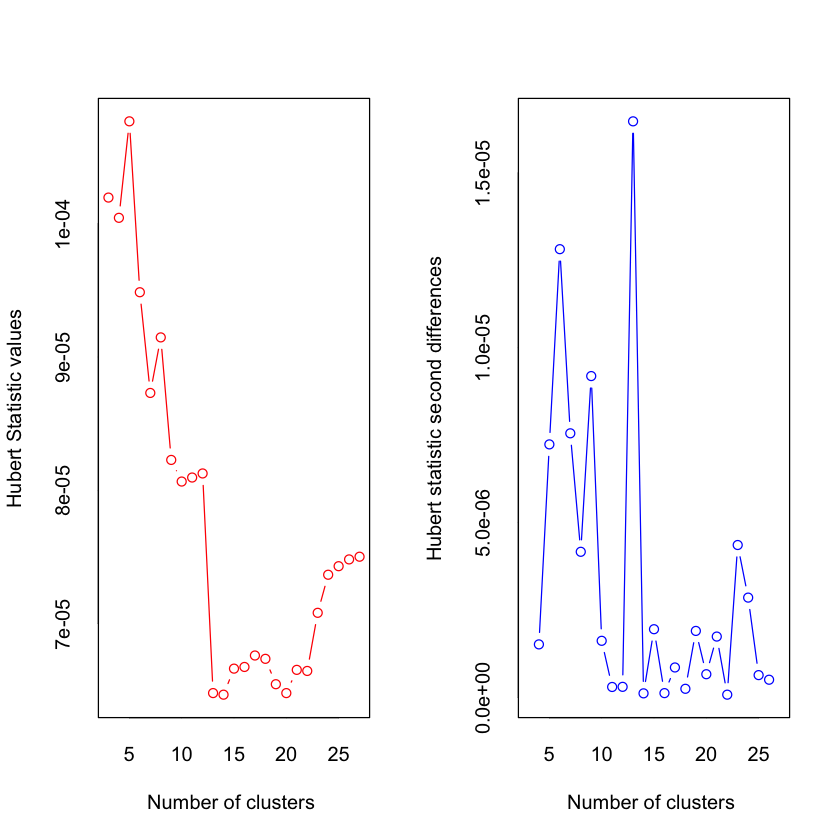

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 9 proposed 3 as the best number of clusters 
* 2 proposed 4 as the best number of clusters 
* 2 proposed 7 as the best number of clusters 
* 1 proposed 12 as the best number of clusters 
* 3 proposed 13 as the best number of clusters 
* 1 proposed 19 as the best number of clusters 
* 1 proposed 20 as the best number of clusters 
* 1 proposed 21 as the best number of clusters 
* 2 proposed 22 as the best number of clusters 
* 1 proposed 25 as the best number of clusters 
* 1 proposed 27 as the best number of clusters 

                   ***** 

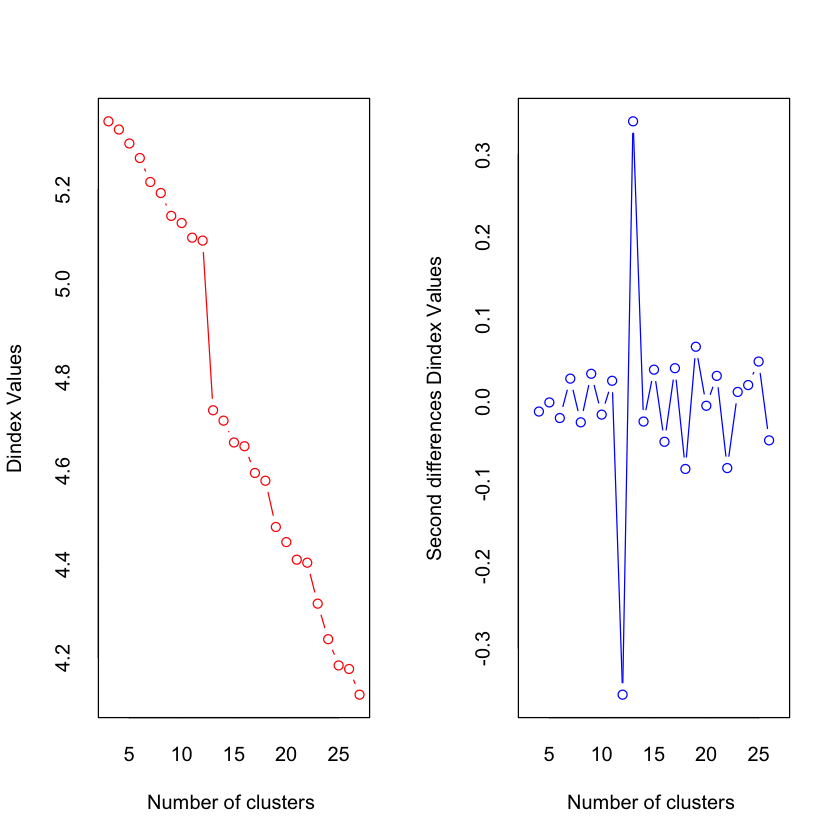

In [7]:
pcas <- foreach(n = seq(length(prelim_stms))) %dopar% prcomp(x = (prelim_stms[[n]]$theta), scale. = T)

nbcs <- foreach(n = seq(length(pcas))) %dopar% NbClust(data = select(data.frame(pcas[[n]]$x),
                                                                     1:(prelim_stms[[n]]$settings$dim$K - 5)),
                                                       diss = daisy(pcas[[n]]$x),
                                                       distance=NULL,
                                                       min.nc=3,
                                                       max.nc=27,
                                                       method='complete',
                                                       index='all')

This code picks the best number of topics (clusters) for each dataset based on popular vote by the clustering algorithms (excluding the filtered methods). The methods filtered out consistently choose the lowest number of clusters in the provided range and are best not considered for our purposes.

In [8]:
k_candidates <- c()
for(i in seq(nbcs)) {
    num_clust <- data.frame(method=nbcs[[i]]$Best.nc %>% t %>% rownames,
               nc=nbcs[[i]]$Best.nc %>% t %>% as.data.frame() %>% pull(1)) %>% 
                    filter(method != 'Cindex' & method != 'DB' & method != 'Silhouette' &
                           method != 'Duda' & method != 'PseudoT2' & method != 'Beale' &
                           method != 'McClain' & method != 'Hubert' & method != 'Dindex')
    num_clust %<>% pull(2) %>% table %>% data.frame %>% arrange(-Freq) %>% slice(1) %>% pull(1)
    k_candidates %<>% c(levels(num_clust)[num_clust] %>% as.numeric)
}

## Improved STMs
Using NbClust recommended numbers of topics (stored in the array k_candidates).

In [11]:
start <- Sys.time()
verbosity <- FALSE

improved_stms <- foreach(n = seq(length(questions))) %dopar% stm(documents = docs[[n]]$documents,
                                                                 vocab = docs[[n]]$vocab, K = k_candidates[n],
                                                                 data = docs[[n]]$meta, verbose = verbosity,
                                                                 seed = seed)

time_taken <- Sys.time() - start
time_taken

Time difference of 18.36213 secs

### Outputting STM Data
To be used with the webapp (which can be downloaded from https://github.com/ArtsEngine/arts-engagement-project/blob/master/STM_Tree_Viz.html)

The webapp will load the json named data.js in the same directory, so make a copy of any of the outputted data and rename it data.js, and open the html file in your browser to view.

In [12]:
question_names <- c()
for(i in seq(questions)) {
    question_names %<>% c(names(questions[[i]][1]))
}

In [47]:
# set directory to save to
directory = './'

for (n in seq(length(questions))) {
    for (threshold in seq(0,2,0.1)) {
        possible_error <- tryCatch(
          create_json(
                stm = improved_stms[[n]],
                documents_raw = questions[[n]][question_names[n]] %>% slice(-procs[[n]]$docs.removed) %>% 
                                                                       slice(-docs[[n]]$docs.removed) %>% 
                                                                       pull,
                documents_matrix = docs[[n]]$documents,
                column_name = question_names[[n]],
                title = names(questions[n]),
                clustering_thresh = threshold,
                verbose = T,
                directory = directory
          ), error = function(msg) msg)
        if (!inherits(possible_error, "error")) break
    }
}

Performing hierarchical topic clustering ... 
Generating JSON representation of the model ... 


## STM Refinement
Use this space to change the number of topics, lower.thresh, and stopwords of questions to try to make a qualitatively better model after having inspecting/comparing the model in the STM viewer webapp. A good place to start is looking at how well defined the no/none topic is.

Be sure to write down the question number, best number of topics, and custom stop words

In [99]:
i <- 1 # question index number to modify
ntopics <- 17

procs[[i]] <- textProcessor(documents = questions[[i]][[1]], 
              metadata = questions[[i]][2],
              customstopwords = c('art','arts'))

docs[[i]] <- prepDocuments(documents = procs[[i]]$documents,
              vocab = procs[[i]]$vocab,
              meta = procs[[i]]$meta,
              lower.thresh = ifelse(procs[[i]]$documents %>% length > 1000, 4, 3))

start <- Sys.time()
stmobj <- stm(documents = docs[[i]]$documents,
                vocab = docs[[i]]$vocab,
                K = ntopics,
                data = docs[[i]]$meta,
                verbose = F, seed = seed)
print(Sys.time() - start)

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Remove Custom Stopwords...
Removing numbers... 
Stemming... 
Creating Output... 
Removing 1571 of 2088 terms (2184 of 10266 tokens) due to frequency 
Removing 12 Documents with No Words 
Your corpus now has 1043 documents, 517 terms and 8082 tokens.Time difference of 4.885605 secs


In [49]:
# set directory to save to
directory = './'
# names the json data.json
datajson = TRUE

# comment out one of the following 2 lines
labels <- NULL
# labels <- read_json('labels/sr_othergrowth_labels.json')

if (is.null(labels)) {
    labels$topics <- NULL
    labels$clusters <- NULL
}

for (threshold in seq(0,2,0.1)) {
    possible_error <- tryCatch(
      create_json(
        stm = stmobj,
        documents_raw = questions[[i]][question_names[i]] %>% slice(-procs[[i]]$docs.removed) %>% 
                                                               slice(-docs[[i]]$docs.removed) %>% 
                                                               pull,
        documents_matrix = docs[[i]]$documents,
        column_name = question_names[[i]],
        title = names(questions[i]),
        clustering_thresh = threshold,
        instant = datajson,
        verbose = T,
        topic_labels = labels$topics,
        cluster_labels = labels$clusters,
        directory = directory
    ), error = function(msg) msg)
    if (!inherits(possible_error, "error")) break
}

Performing hierarchical topic clustering ... 
